## READ DATA


In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [ ]:
!pip install catboost
import catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df_clk    = pd.read_csv('/content/gdrive/MyDrive/Final Project/Copy of click_stream.csv')
df_cust   = pd.read_csv('/content/gdrive/MyDrive/Final Project/Copy of customer.csv')
df_pro    = pd.read_csv('/content/gdrive/MyDrive/Final Project/Copy of product.csv', error_bad_lines=False)
df_trans  = pd.read_csv('/content/gdrive/MyDrive/Final Project/Copy of transactions.csv')

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

## CLICK STREAM

In [ ]:
df_clk

In [ ]:
df_clk.info()

In [ ]:
df_clk['event_name'].unique()

In [ ]:
dfcs_Sch = df_clk[df_clk['event_name']=='SEARCH'].reset_index().drop(columns=['index'])

In [ ]:
dfcs_Sch.head()

In [ ]:
dfcs_Sch.insert(loc = 5, column = 'SK', value = dfcs_Sch['event_metadata'].str.split(": ").str.get(1))

In [ ]:
dfcs_Sch.insert(loc = 5, column = 'search_keywords', value = dfcs_Sch['SK'].str.split("'").str.get(1))

In [ ]:
#nULL
dfcs_Search = dfcs_Sch.drop(columns=['event_metadata', 'SK'])

In [ ]:
dfcs_Search.head()

In [ ]:
df_clk = dfcs_Search.copy()

In [ ]:
df_clk.isna().values.any()

In [ ]:
df_clk.duplicated().values.any()

In [ ]:
#Manipulating event_time
df_clk['event_time'] = pd.to_datetime(df_clk['event_time']).dt.date
df_clk.head()

In [ ]:
df_clk['event_time'] = pd.to_datetime(df_clk['event_time'], format='%Y-%m-%d')
df_clk.info()

In [ ]:
df_clk.to_csv(r'C:\Users\aryop\Documents\export_dataframe.csv', index=False)

## Clickstream - EDA

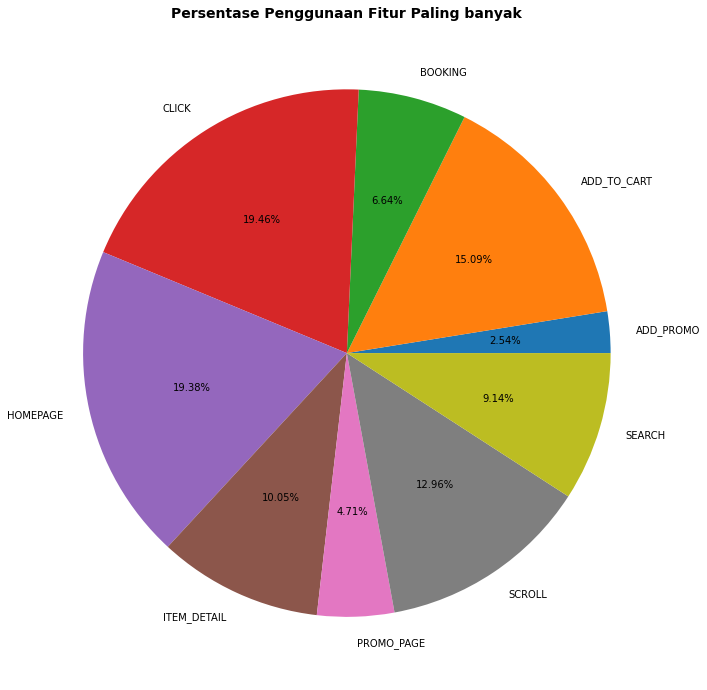

In [ ]:
#Mencari fitur paling laku

top_event = df_clk.groupby('event_name')['event_id'].count().reset_index()
plt.figure(figsize = (10, 10))
plt.pie(data = top_event, x = 'event_id', labels = 'event_name', autopct = '%1.2f%%')
plt.title('Persentase Penggunaan Fitur Paling banyak', fontweight = 'bold', fontdict = {'fontsize' : 14})
plt.rcParams['font.size'] = 12
plt.tight_layout()

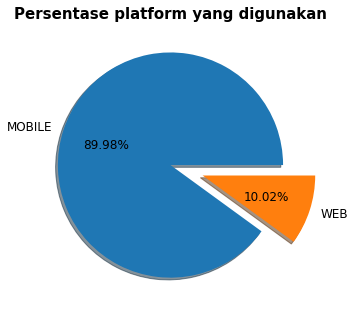

In [ ]:
#Mencari platform yang sering digunakan
top_platform = df_clk.groupby('traffic_source')['event_id'].count().reset_index()
plt.figure(figsize = (5, 5))
plt.pie(explode=[0,0.3], data = top_platform, x = 'event_id', labels = 'traffic_source', autopct = '%1.2f%%',shadow=True)
plt.title('Persentase platform yang digunakan', fontweight = 'bold', fontdict = {'fontsize' : 15})
plt.rcParams['font.size'] = 12
plt.tight_layout()

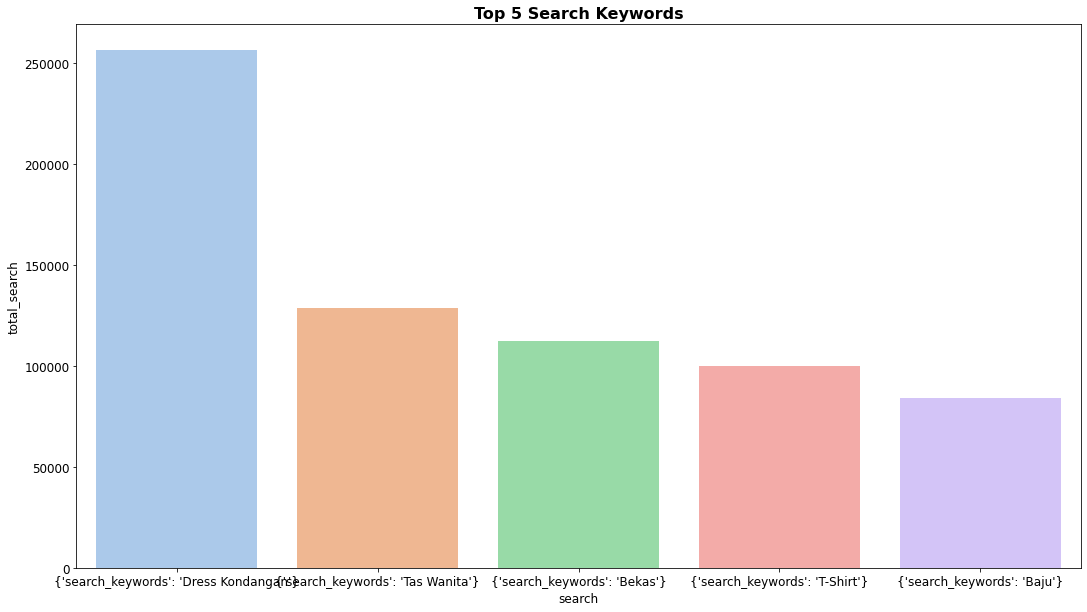

In [ ]:
keywords = df_clk[df_clk['event_name'] == 'SEARCH']['event_metadata'].value_counts()[:5].reset_index()
keywords = keywords.rename(columns = {'index' : 'search', 'event_metadata' : 'total_search'})

plt.figure(figsize = (18, 10))
sns.barplot(data = keywords, x = 'search', y = 'total_search', palette = "pastel")
plt.title('Top 5 Search Keywords', fontweight = 'bold', fontdict = {'fontsize' : 16})
plt.rcParams['font.size'] = 10

In [ ]:
# clickstream different event_name with column name (event) and (jumlah_total)
events = pd.DataFrame(df_clk['event_name'].value_counts().reset_index().rename(columns={'index':'event', 'event_name':'jumlah_total'}))

# add percentage two digit after comma (persentase_jumlah_total)
events['persentase_jumlah_total'] = events['jumlah_total'].apply(lambda x: "{:.2f}%".format(x/events['jumlah_total'].sum()*100))

# add count customer_id with transactions (jumlah_customer)
events['jumlah_customer'] = events['event'].apply(lambda x: df_trans.merge(df_clk[df_clk['event_name'] == x] , how = 'inner', on = 'session_id')['customer_id'].nunique())

# add percentage two digit after comma (persentase_jumlah_customer)
events['persentase_jumlah_customer'] = events['jumlah_customer'].apply(lambda x: "{:.2f}%".format(x/df_cust['customer_id'].count()*100))

events

,event,jumlah_total,persentase_jumlah_total,jumlah_customer,persentase_jumlah_customer
0,CLICK,2498038,19.46%,46733,46.73%
1,HOMEPAGE,2487126,19.38%,50704,50.70%
2,ADD_TO_CART,1937157,15.09%,50704,50.70%
3,SCROLL,1663571,12.96%,44452,44.45%
4,ITEM_DETAIL,1290396,10.05%,43827,43.83%
5,SEARCH,1173266,9.14%,42165,42.16%
6,BOOKING,852582,6.64%,50704,50.70%
7,PROMO_PAGE,604931,4.71%,39064,39.06%
8,ADD_PROMO,326535,2.54%,38879,38.88%


## CUSTOMER

In [ ]:
df_cust

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,34743,Manah,Mustofa,bf989ab1-d7eb-4ad5-b4bc-29e3cf69b35c,bf989ab1_d7eb_4ad5_b4bc_29e3cf69b35c@startupca...,M,2000-11-17,Android,fa1914a5-0c12-4393-8d6c-af4e4a4de6aa,Android 4.3.1,-5.203523,105.635530,Lampung,Indonesia,2020-10-17
99996,72065,Danu,Pradana,4af2b3d5-c573-4032-b29c-24782745a2f6,4af2b3d5_c573_4032_b29c_24782745a2f6@startupca...,M,1998-03-30,Android,d8234d67-6954-4e05-8293-d37ef25bfd7e,Android 8.0.0,4.474702,95.904876,Aceh,Indonesia,2017-11-25
99997,32818,Talia,Aryani,af0edbfa-f354-4765-813b-b9f151022555,af0edbfa_f354_4765_813b_b9f151022555@startupca...,F,1993-01-12,Android,3c586f64-aab7-4dd6-be94-5d47c6361081,Android 11,-3.330376,127.028348,Maluku,Indonesia,2018-09-01
99998,75597,Ajimat,Mansur,35cd82f3-6b86-42a2-bb15-933770d7f250,35cd82f3_6b86_42a2_bb15_933770d7f250@startupca...,M,2000-09-13,Android,3b209c58-d305-4b46-9363-b90a3914f008,Android 7.1,-2.173114,101.495913,Jambi,Indonesia,2020-05-31


In [ ]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

In [ ]:
df_cust.isna().values.any()

False

In [ ]:
df_cust.duplicated().values.any()

False

In [ ]:
#Manipulating kolom fisrt_name dan last_name
df_cust.insert(loc = 3, column = 'full_name', value = df_cust['first_name'] + ' ' + df_cust['last_name'])
df_cust.head()

,customer_id,first_name,last_name,full_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,Lala Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,Maimunah Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,Bakiman Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,Cahyadi Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,Irnanto Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [ ]:
#Manipulating Dtype birthdate dan first_join_date
df_cust['birthdate'] = pd.to_datetime(df_cust['birthdate'], format='%Y-%m-%d')
df_cust['first_join_date'] = pd.to_datetime(df_cust['first_join_date'], format='%Y-%m-%d')
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         100000 non-null  int64         
 1   first_name          100000 non-null  object        
 2   last_name           100000 non-null  object        
 3   full_name           100000 non-null  object        
 4   username            100000 non-null  object        
 5   email               100000 non-null  object        
 6   gender              100000 non-null  object        
 7   birthdate           100000 non-null  datetime64[ns]
 8   device_type         100000 non-null  object        
 9   device_id           100000 non-null  object        
 10  device_version      100000 non-null  object        
 11  home_location_lat   100000 non-null  float64       
 12  home_location_long  100000 non-null  float64       
 13  home_location       100000 non

In [ ]:
#Manipulating kolom gender
df_cust['gender'].unique()

array(['F', 'M'], dtype=object)

In [ ]:
df_cust['gender'] = df_cust['gender'].map({'M': 'Male', 'F': 'Female'})

In [ ]:
df_cust['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
#Split kolom device_version
df_cust['device_version']= df_cust['device_version'].str.split(";").str.get(0)
df_cust['device_version']

0               iPhone
1        Android 2.2.1
2                 iPad
3                 iPad
4               iPhone
             ...      
99995    Android 4.3.1
99996    Android 8.0.0
99997       Android 11
99998      Android 7.1
99999    Android 3.2.6
Name: device_version, Length: 100000, dtype: object

In [ ]:
df_cust['device_version']= df_cust['device_version'].str.split(" ").str.get(0)
df_cust.head()

,customer_id,first_name,last_name,full_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,Lala Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,Female,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,Maimunah Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,Female,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,Bakiman Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,Male,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,Cahyadi Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,Male,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,Irnanto Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,Male,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [ ]:
#Menggabungkan kolom device_type dan device_version
df_cust = df_cust.drop(["device_type"], axis = 1)
df_cust.head()

,customer_id,first_name,last_name,full_name,username,email,gender,birthdate,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,Lala Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,Female,1996-06-14,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,Maimunah Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,Female,1993-08-16,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,Bakiman Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,Male,1989-01-23,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,Cahyadi Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,Male,1991-01-05,f4c18515-c5be-419f-8142-f037be47c9cd,iPad,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,Irnanto Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,Male,2000-07-15,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [ ]:
#Menentukan umur customer
from datetime import datetime
sekarang = datetime.now()
df_cust.insert(loc = 8, column = 'age_customer', value = sekarang.year-(df_cust.birthdate.dt.year))
df_cust.head()

,customer_id,first_name,last_name,full_name,username,email,gender,birthdate,age_customer,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,Lala Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,Female,1996-06-14,26,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,Maimunah Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,Female,1993-08-16,29,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,Bakiman Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,Male,1989-01-23,33,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,Cahyadi Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,Male,1991-01-05,31,f4c18515-c5be-419f-8142-f037be47c9cd,iPad,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,Irnanto Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,Male,2000-07-15,22,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


### Customer - EDA

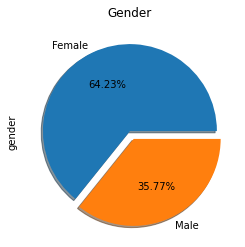

In [ ]:
df_cust['gender'].value_counts().plot(kind = 'pie', explode=[0,0.1],title = 'Gender', autopct = '%1.2f%%', shadow=True)

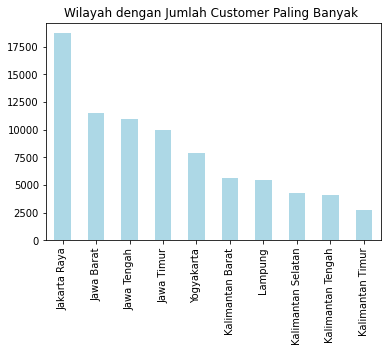

In [ ]:
# Wilayah dengan Jumlah Customer Paling Banyak

df_cust["home_location"].value_counts()[:10].plot(kind='bar', color='lightblue', title='Wilayah dengan Jumlah Customer Paling Banyak ')

## PRODUCT

In [ ]:
df_pro

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [ ]:
df_pro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [ ]:
df_pro.isna().values.any()

True

In [ ]:
# Run if result from df_pro.isna().values.any() is True
df_pro.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [ ]:
df_pro['baseColour'].fillna('unnamed', inplace=True)
df_pro['season'].fillna('unnamed', inplace=True)
df_pro['year'].fillna(0, inplace=True)
df_pro['usage'].fillna('unnamed', inplace=True)
df_pro['productDisplayName'].fillna('unnamed', inplace=True)
df_pro.isna().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [ ]:
df_pro.duplicated().values.any()

False

In [ ]:
#Manipulating Dtype year
df_pro['year'] = df_pro['year'].astype('int')
df_pro.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [ ]:
#Mengubah nama kolom id menjadi product_id
df_pro = df_pro.set_axis(['product_id', 'gender_product_type', 'masterCategory', 'subCategory', 'articleType',
                          'baseColour', 'season', 'year_of_product', 'usage', 'productDisplayName'], axis='columns', inplace=False)
df_pro.head()

,product_id,gender_product_type,masterCategory,subCategory,articleType,baseColour,season,year_of_product,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [ ]:
#Manipulating kolom gender_product_type
df_pro['gender_product_type'].unique()

array(['Men', 'Women', 'Boys', 'Girls', 'Unisex'], dtype=object)

In [ ]:
df_pro['gender_product_type'] = df_pro['gender_product_type'].map({'Men': 'Male', 'Women': 'Female', 'Boys': 'Male', 'Girls': 'Female', 'Unisex': 'Others'})

In [ ]:
df_pro.head()

,product_id,gender_product_type,masterCategory,subCategory,articleType,baseColour,season,year_of_product,usage,productDisplayName
0,15970,Male,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Male,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Female,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Male,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Male,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [ ]:
pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_pro.to_excel('data.xls', sheet_name='Sheet1', index=False, engine='xlsxwriter')

### Product - EDA

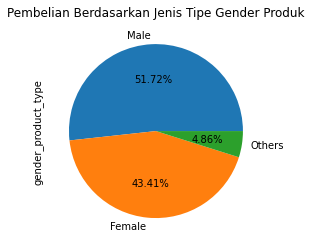

In [ ]:
# Menentukan barang paling banyak dibeli berdasarkan gender

df_pro['gender_product_type'].value_counts().plot(kind = 'pie', title = 'Pembelian Berdasarkan Jenis Tipe Gender Produk', autopct = '%1.2f%%')

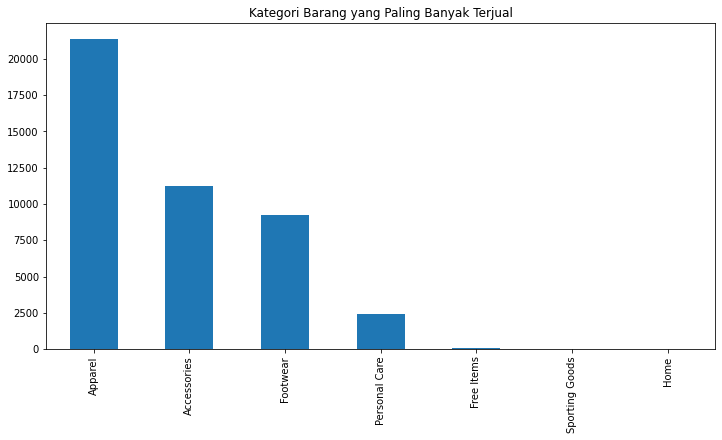

In [ ]:
# Menampilkan kategori barang yang paling banyak dibeli

df_pro['masterCategory'].value_counts().plot(kind='bar', figsize=(12,6), title = "Kategori Barang yang Paling Banyak Terjual")

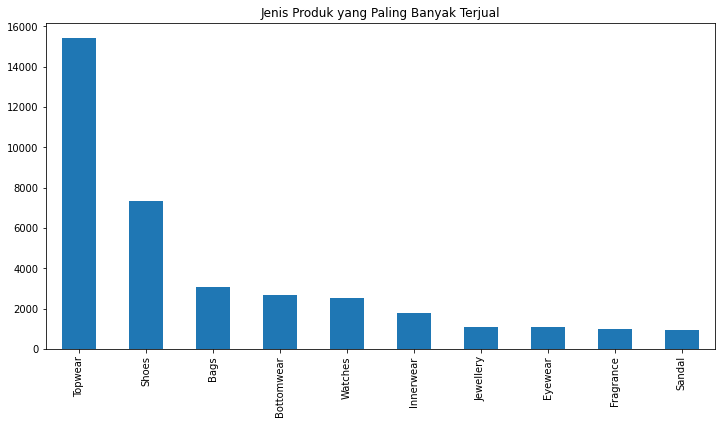

In [ ]:
# Menampikan jenis produk yang paling banyak dibeli

df_pro['subCategory'].value_counts()[:10].plot(kind='bar', figsize=(12,6), title = "Jenis Produk yang Paling Banyak Terjual")

## TRANSACTION

In [ ]:
df_trans.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


In [ ]:
trans_2 = df_trans.copy()

In [ ]:
#Split kolom product_metadata menjadi kolom product_id, quantitiy, dan item_price
import ast

trans_2['product_metadata'] = trans_2['product_metadata'].apply(ast.literal_eval)
trans_2 = trans_2.explode('product_metadata')
trans_2[list(trans_2['product_metadata'].head(1).tolist()[0].keys())] = trans_2['product_metadata'].apply(lambda x: pd.Series([x[key] for key in x.keys()]))

In [ ]:
trans_2['product_metadata'].iloc[9]

{'product_id': 53051, 'quantity': 1, 'item_price': 292052}

In [ ]:
del trans_2['product_metadata']
trans_2

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852579,2021-09-21T22:10:05.074873Z,25121,66f02fa4-c62e-497a-8b6e-be239009b50a,484eecde-9f4a-42de-a8df-7ce6668101f4,Debit Card,Failed,0,NaN,0,2021-09-27T00:43:40.992167Z,-6.869535,111.077145,226820,30642,2,113410
852580,2021-12-09T07:35:18.222046Z,34829,ccde6b83-ee42-4cce-b2cd-976574886eac,954e1211-4d45-4d0b-ba84-53e80119592c,OVO,Success,5010,AZ2022,10000,2021-12-12T07:52:44.803822Z,-8.677264,115.176947,359203,19394,1,354213
852581,2021-12-11T01:20:36.944593Z,99645,5bcd3434-1dc6-44bb-ae63-fd19714cbd6c,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,Credit Card,Success,2181,WEEKENDSERU,5000,2021-12-12T13:28:22.848703Z,-6.185498,106.831093,1158159,13079,4,288835
852582,2019-12-18T11:01:09.623382Z,87319,af7f291a-b01b-4bfd-89a9-237b16368b15,bb6e5426-a3f3-426a-b99d-79173eaa234b,Credit Card,Success,4503,AZ2022,0,2019-12-23T22:56:46.831720Z,-7.155977,110.891858,184143,11312,1,188646


In [ ]:
df_trans = trans_2.copy()

In [ ]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254585 entries, 0 to 852583
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   created_at              1254585 non-null  object 
 1   customer_id             1254585 non-null  int64  
 2   booking_id              1254585 non-null  object 
 3   session_id              1254585 non-null  object 
 4   payment_method          1254585 non-null  object 
 5   payment_status          1254585 non-null  object 
 6   promo_amount            1254585 non-null  int64  
 7   promo_code              481139 non-null   object 
 8   shipment_fee            1254585 non-null  int64  
 9   shipment_date_limit     1254585 non-null  object 
 10  shipment_location_lat   1254585 non-null  float64
 11  shipment_location_long  1254585 non-null  float64
 12  total_amount            1254585 non-null  int64  
 13  product_id              1254585 non-null  int64  
 14  qua

In [ ]:
df_trans.isna().values.any()

True

In [ ]:
# Run if result from df_trans.isna().values.any() is True
df_trans.isna().sum()

created_at                     0
customer_id                    0
booking_id                     0
session_id                     0
payment_method                 0
payment_status                 0
promo_amount                   0
promo_code                773446
shipment_fee                   0
shipment_date_limit            0
shipment_location_lat          0
shipment_location_long         0
total_amount                   0
product_id                     0
quantity                       0
item_price                     0
dtype: int64

In [ ]:
df_trans[df_trans.isnull().any(axis = 1)].head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753
6,2019-03-22T11:53:02.365620Z,4774,c0ced313-e6b1-4a2a-b21f-347eccda5f96,e140f1f1-6da1-42b3-b2d1-56ac6fc72d4a,Credit Card,Success,0,NaN,10000,2019-03-27T14:40:13.181562Z,-7.712608,110.502877,306599,53136,1,296599


In [ ]:
df_trans.dropna(inplace=True)

In [ ]:
df_trans.isnull().sum()

created_at                0
customer_id               0
booking_id                0
session_id                0
payment_method            0
payment_status            0
promo_amount              0
promo_code                0
shipment_fee              0
shipment_date_limit       0
shipment_location_lat     0
shipment_location_long    0
total_amount              0
product_id                0
quantity                  0
item_price                0
dtype: int64

In [ ]:
df_trans.duplicated().values.any()

False

In [ ]:
#Manipulating Dtype created_at, shipment_date_limit
df_trans['created_at'] = pd.to_datetime(df_trans['created_at']).dt.date
df_trans['shipment_date_limit'] = pd.to_datetime(df_trans['shipment_date_limit']).dt.date
df_trans['created_at'] = pd.to_datetime(df_trans['created_at'], format='%Y-%m-%d')
df_trans['shipment_date_limit'] = pd.to_datetime(df_trans['shipment_date_limit'], format='%Y-%m-%d')
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481139 entries, 0 to 852583
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   created_at              481139 non-null  datetime64[ns]
 1   customer_id             481139 non-null  int64         
 2   booking_id              481139 non-null  object        
 3   session_id              481139 non-null  object        
 4   payment_method          481139 non-null  object        
 5   payment_status          481139 non-null  object        
 6   promo_amount            481139 non-null  int64         
 7   promo_code              481139 non-null  object        
 8   shipment_fee            481139 non-null  int64         
 9   shipment_date_limit     481139 non-null  datetime64[ns]
 10  shipment_location_lat   481139 non-null  float64       
 11  shipment_location_long  481139 non-null  float64       
 12  total_amount            481139

In [ ]:
df_trans.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03,-8.227893,111.969107,199832,54728,1,191247
5,2019-02-03,4774,1ed58c46-67fb-4386-924b-983c74ccb4d7,7fa0b583-6d30-40bc-8b61-0f70f5bef30f,Debit Card,Success,6369,WEEKENDMANTAP,5000,2019-02-07,-3.602334,120.363824,181865,59620,1,183234
8,2019-06-24,4774,6edd9366-4788-4bbb-ae5b-744e45e6118d,0d20c278-e082-4f28-9afe-8b5907d7a284,Credit Card,Success,4019,AZ2022,10000,2019-06-28,-6.126016,106.779552,370757,12282,1,364776
9,2019-08-10,4774,771665e9-7df2-41c8-8168-16d5cdd407a1,f5352cdc-0e3c-4e77-af42-645501dcded4,Credit Card,Success,9072,WEEKENDSERU,10000,2019-08-14,-0.992004,114.438739,1295740,53051,1,292052
9,2019-08-10,4774,771665e9-7df2-41c8-8168-16d5cdd407a1,f5352cdc-0e3c-4e77-af42-645501dcded4,Credit Card,Success,9072,WEEKENDSERU,10000,2019-08-14,-0.992004,114.438739,1295740,46352,1,241945


In [ ]:
#Membuat kolom estimated, selisih kolom shipment_date_limit dan created_at
df_trans.insert(loc = 10, column = 'estimated', value = df_trans['shipment_date_limit'] - df_trans['created_at'])

In [ ]:
#Manipulating Dtype
df_trans['estimated'] = df_trans['estimated'].astype('str')

In [ ]:
df_trans['estimated'] = df_trans['estimated'].str.split(' ').str.get(0)

In [ ]:
df_trans['estimated'] = df_trans['estimated'].astype('int')

In [ ]:
df_trans.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,estimated,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03,5,-8.227893,111.969107,199832,54728,1,191247
5,2019-02-03,4774,1ed58c46-67fb-4386-924b-983c74ccb4d7,7fa0b583-6d30-40bc-8b61-0f70f5bef30f,Debit Card,Success,6369,WEEKENDMANTAP,5000,2019-02-07,4,-3.602334,120.363824,181865,59620,1,183234
8,2019-06-24,4774,6edd9366-4788-4bbb-ae5b-744e45e6118d,0d20c278-e082-4f28-9afe-8b5907d7a284,Credit Card,Success,4019,AZ2022,10000,2019-06-28,4,-6.126016,106.779552,370757,12282,1,364776
9,2019-08-10,4774,771665e9-7df2-41c8-8168-16d5cdd407a1,f5352cdc-0e3c-4e77-af42-645501dcded4,Credit Card,Success,9072,WEEKENDSERU,10000,2019-08-14,4,-0.992004,114.438739,1295740,53051,1,292052
9,2019-08-10,4774,771665e9-7df2-41c8-8168-16d5cdd407a1,f5352cdc-0e3c-4e77-af42-645501dcded4,Credit Card,Success,9072,WEEKENDSERU,10000,2019-08-14,4,-0.992004,114.438739,1295740,46352,1,241945


### Transaction - EDA

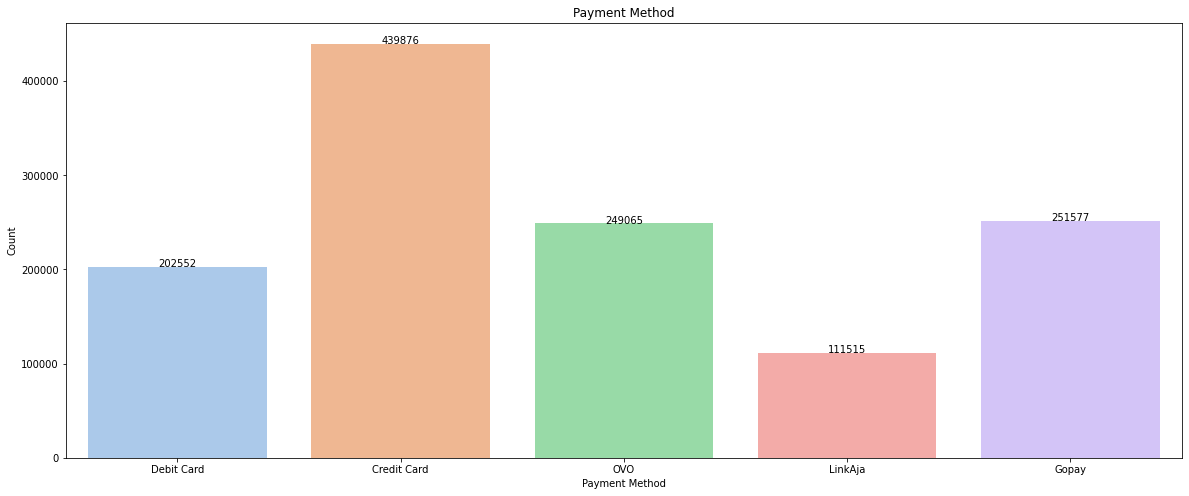

In [ ]:
# Menampilkan metode pembayaran yang paling banyak digunakan

plt.figure(figsize = (20, 8))
ax = sns.countplot(x='payment_method',data=trans_2, palette = "pastel")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.title('Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()

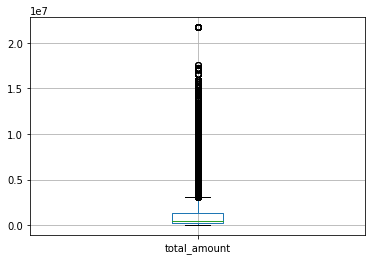

In [ ]:
#Plotting the boxplot for the delivery time (excluding the outliers):
# plt.figure(figsize = (12, 3.5))
# sns.boxplot(df_trans.total_amount, showfliers = False)
# plt.xlabel("Total Amount", fontsize = 14)
# plt.yticks([])
# plt.title('Persebaran payment amount per-transactions by customer', fontsize = 15)
df_trans.boxplot(column = ["total_amount"])
plt.show()

# Churn Label

## Split Data Train dan Test

In [ ]:
# Merge semua dataframe
df_full= df_cust.merge(df_trans, on="customer_id")
df_full= df_full.merge(df_clk, on="session_id")
df_full= df_full.merge(df_pro, on="product_id")
df_full.shape

(738950, 46)

In [ ]:
df_full.isna().values.any()

False

In [ ]:
#waktu order paling lama
df_full['created_at'].min()

Timestamp('2016-07-01 00:00:00')

In [ ]:
#waktu order terbaru
df_full['created_at'].max()

Timestamp('2022-07-31 00:00:00')

In [ ]:
#count baris tiap bulan di tahun 2022
pd.to_datetime(df_full[(df_full['created_at'] >= '2022-01-01')]['created_at']).dt.month.value_counts()

6    24105
5    23182
4    23074
7    22972
3    22223
1    21970
2    18849
Name: created_at, dtype: int64

In [ ]:
#akan dilakukan prediksi dibulan ke 8 tahun 2022

#Dataset akan dibagi menjadi 3 bagian, antara lain :

#Test :
#Tanggal lebih dari sama dengan 2022-07-01 (test)

#Train (+Label) 6 bulan kebelakang
#Train bulan 3-5 -> label bulan 6
#Train bulan 2-4 -> label bulan 5
#Train bulan 1-3 -> label bulan 4

In [ ]:
# temp dataframe buat tabel final 360 customers
df_temp_original = df_cust.iloc[:,0:15].merge(df_trans, how="inner", on="customer_id").iloc[:,0:15]
print(df_temp_original.describe())

         customer_id   age_customer  home_location_lat  home_location_long
count  481139.000000  481139.000000      481139.000000       481139.000000
mean    49728.301052      26.312833          -5.096514          110.946279
std     29001.205756       7.274538           3.093714            6.460070
min         3.000000       6.000000         -10.812034           95.312071
25%     24380.000000      21.000000          -7.367436          106.860071
50%     49431.000000      26.000000          -6.242532          110.142859
75%     74808.000000      31.000000          -3.061557          113.209113
max     99998.000000      68.000000           5.551825          140.979912


In [ ]:
# Buat dataframe baru berdasarkan created_at :

# TEST
#  > 1. Tanggal lebih dari sama dengan 2022-07-01 (test)

# TRAIN
#  > 1. Train bulan 3-5 -> label bulan 6
#  > 2. Train bulan 2-4 -> label bulan 5
#  > 3. Train bulan 1-3 -> label bulan 4

# TEST
# df_orders_test = df_trans[df_trans['created_at'] >= '2022-07-01']
df_test = df_full[(df_full['created_at'] >= '2022-07-01') & (df_full['created_at'] < '2022-08-01')]

# LABEL
#df_orders_label_6 = df_trans[(df_trans['created_at'] >= '2022-06-01') & (df_trans['created_at'] < '2022-07-01')]
#df_orders_label_5 = df_trans[(df_trans['created_at'] >= '2022-05-01') & (df_trans['created_at'] < '2022-06-01')]
#df_orders_label_4 = df_trans[(df_trans['created_at'] >= '2022-04-01') & (df_trans['created_at'] < '2022-05-01')]

df_full_train = df_full[(df_full['created_at'] >= '2022-01-01') & (df_full['created_at'] < '2022-06-01')]

# TRAIN
df_train_6 = df_full[(df_full['created_at'] >= '2022-03-01') & (df_full['created_at'] < '2022-06-01')]
df_train_5 = df_full[(df_full['created_at'] >= '2022-02-01') & (df_full['created_at'] < '2022-05-01')]
df_train_4 = df_full[(df_full['created_at'] >= '2022-01-01') & (df_full['created_at'] < '2022-04-01')]

In [ ]:
df_full_train_shape = df_full_train.shape
df_train_4_shape = df_train_4.shape
df_train_5_shape = df_train_5.shape
df_train_6_shape = df_train_6.shape
df_test_shape = df_test.shape

print("Shape Full Train :",df_full_train_shape)
print("Shape Train 4 :",df_train_4_shape)
print("Shape Train 5 :",df_train_5_shape)
print("Shape Train 6 :",df_train_6_shape)
print("Shape Full Test :",df_test_shape)

Shape Full Train : (109298, 46)
Shape Train 4 : (63042, 46)
Shape Train 5 : (64146, 46)
Shape Train 6 : (68479, 46)
Shape Full Test : (22972, 46)


## **Labeling Churn seluruh Data (2016 - 2022)**

In [ ]:
df_full['created_at'].min()

Timestamp('2016-07-01 00:00:00')

In [ ]:
df_full['created_at'].max()

Timestamp('2022-07-31 00:00:00')

**Recency**

In [ ]:
df_all_recency = pd.DataFrame(df_full.groupby(by='customer_id', as_index=False)['created_at'].max())
print(df_all_recency.shape)

(32501, 2)


In [ ]:
df_all_recency.head()

,customer_id,created_at
0,3,2022-04-03
1,15,2022-01-05
2,18,2021-07-23
3,20,2022-06-06
4,24,2021-03-30


In [ ]:
import datetime as dt
present_day = df_all_recency['created_at'].max()
present_day

Timestamp('2022-07-31 00:00:00')

In [ ]:
# apply recency berdasarkan 2022-06-30
df_all_recency['recency'] = df_all_recency['created_at'].apply(lambda x: (present_day - x).days)
print(df_all_recency.shape)

(32501, 3)


In [ ]:
df_all_recency.head()

,customer_id,created_at,recency
0,3,2022-04-03,119
1,15,2022-01-05,207
2,18,2021-07-23,373
3,20,2022-06-06,55
4,24,2021-03-30,488


**Frekuensi**

In [ ]:
df_all_freq = pd.DataFrame(df_full.groupby(["customer_id"]).agg({"product_id":"nunique"}).reset_index())
df_all_freq.rename(columns={"product_id":"frequency"}, inplace=True)
print(df_all_freq.shape)
df_all_freq.head()

(32501, 2)


,customer_id,frequency
0,3,33
1,15,1
2,18,14
3,20,10
4,24,5


**Monetary**

In [ ]:
df_all_monet = df_full.groupby('customer_id', as_index=False)['total_amount'].sum()
df_all_monet.columns = ['customer_id', 'monetary']
print(df_all_monet.shape)
df_all_monet.head()

(32501, 2)


,customer_id,monetary
0,3,38231538
1,15,146640
2,18,17065172
3,20,19934542
4,24,5270357


**RFM Full Data**

In [ ]:
df_rfm_all = df_all_recency.merge(df_all_freq, on='customer_id')
df_rfm_all = df_rfm_all.merge(df_all_monet, on='customer_id').drop(columns='created_at')
print(df_rfm_all.shape)
df_rfm_all.head()

(32501, 4)


,customer_id,recency,frequency,monetary
0,3,119,33,38231538
1,15,207,1,146640
2,18,373,14,17065172
3,20,55,10,19934542
4,24,488,5,5270357


In [ ]:
df_rfm_all.describe()

,customer_id,recency,frequency,monetary
count,32501.000000,32501.000000,32501.000000,3.250100e+04
mean,49764.236116,354.333497,9.493123,2.843466e+07
std,28974.592596,425.206396,16.048666,9.698877e+07
min,3.000000,0.000000,1.000000,3.460000e+04
25%,24714.000000,66.000000,1.000000,7.909740e+05
50%,49666.000000,183.000000,4.000000,3.235439e+06
75%,74908.000000,475.000000,10.000000,1.676017e+07
max,99998.000000,2220.000000,392.000000,5.005723e+09


**Labeling Train Seluruh Bulan**

In [ ]:
# Buat Score R, F, dan M (train)
df_rfm_all['recency_score']  = pd.qcut(df_rfm_all['recency'], 5, labels=[5, 4, 3, 2, 1])
df_rfm_all['frequency_score']= pd.qcut(df_rfm_all['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_rfm_all['monetary_score'] = pd.qcut(df_rfm_all['monetary'], 5, labels=[1, 2, 3, 4, 5])
print(df_rfm_all.shape)
df_rfm_all.head()

(32501, 7)


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,3,119,33,38231538,4,5,5
1,15,207,1,146640,3,1,1
2,18,373,14,17065172,2,5,4
3,20,55,10,19934542,4,4,4
4,24,488,5,5270357,2,3,3


In [ ]:
# Buat datafram untuk train menggunakan rfm_score integer
df_rfm_all = df_rfm_all.copy()
df_rfm_all['RFM_score'] =  df_rfm_all.recency_score.astype(int) + df_rfm_all.frequency_score.astype(int) + df_rfm_all.monetary_score.astype(int)
df_rfm_all

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,3,119,33,38231538,4,5,5,14
1,15,207,1,146640,3,1,1,5
2,18,373,14,17065172,2,5,4,11
3,20,55,10,19934542,4,4,4,12
4,24,488,5,5270357,2,3,3,8
...,...,...,...,...,...,...,...,...
32496,99986,118,18,27214445,4,5,5,14
32497,99987,252,26,65623254,3,5,5,13
32498,99988,27,19,19618770,5,5,4,14
32499,99995,86,13,71005098,4,5,5,14


## **Segmentation Full Data**

In [ ]:
#Segmentasi Map, source: https://documentation.bloomreach.com/engagement/docs/rfm-segmentation
segmentation_map= {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [ ]:
df_rfm_all_seg = df_rfm_all.copy()
df_rfm_all_seg['segmentation'] = df_rfm_all_seg['recency_score'].astype(str) + df_rfm_all_seg['frequency_score'].astype(str) + df_rfm_all_seg['monetary_score'].astype(str)
df_rfm_all_seg['segmentation'] = df_rfm_all_seg['segmentation'].replace(segmentation_map, regex=True)
print(df_rfm_all_seg.shape)
df_rfm_all_seg.head()

(32501, 9)


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,segmentation
0,3,119,33,38231538,4,5,5,14,Champions
1,15,207,1,146640,3,1,1,5,New Customers
2,18,373,14,17065172,2,5,4,11,At Risk
3,20,55,10,19934542,4,4,4,12,Loyal
4,24,488,5,5270357,2,3,3,8,Hibernating customers


In [ ]:
df_rfm_all_seg['segmentation'].nunique

<bound method IndexOpsMixin.nunique of 0                    Champions
1                New Customers
2                      At Risk
3                        Loyal
4        Hibernating customers
                 ...          
32496                Champions
32497                    Loyal
32498                Champions
32499                Champions
32500                    Loyal
Name: segmentation, Length: 32501, dtype: object>

In [ ]:
#Agregasi mean, median, min, max, count setiap R, F, dan M
df_rfm_all_seg = df_rfm_all_seg[["segmentation", "recency", "frequency", "monetary"]].groupby("segmentation").agg(['mean','median', 'min', 'max', 'count'])
df_rfm_all_seg

recency                           frequency         \
                              mean  median  min   max count       mean median   
segmentation                                                                    
About To Sleep          299.327599   262.0  125   587  1337   1.324607    1.0   
At Risk                 598.187000   464.0  267  2212  3000   7.825000    6.0   
Cannot Lose Them        959.054581   827.0  274  2197   513   6.623782    6.0   
Champions                46.961778    41.0    0   124  6410  29.545866   22.0   
Hibernating customers   505.756292   415.0  125  2213  6397   2.149601    2.0   
Lost customers         1145.716422  1055.0  588  2220  3477   1.050906    1.0   
Loyal                   140.453558   141.0    0   266  3499  13.721635   10.0   
Need Attention          123.822969   115.0    0   266  1785   5.721008    6.0   
New Customers           108.965593    96.0    0   266  2267   1.188355    1.0   
Potential Loyalist      107.451270    95.0    0   266  2914   3.667124    4.0   
Promising                40.823725    28.0    0   266   902   1.656319    2.0   

                                          monetary                       \
                      min  max count          mean      median      min   
segmentation                                                              
About To Sleep          1    4  1337  6.481157e+05    445589.0    55090   
At Risk                 1   57  3000  2.615131e+07   9451396.0   991912   
Cannot Lose Them        1   24   513  2.733096e+07  10294377.0  1823048   
Champions               5  392  6410  1.033521e+08  49816344.0  5899580   
Hibernating customers   1    5  6397  1.413406e+06   1109451.0    40034   
Lost customers          1    3  3477  4.540698e+05    352906.0    34600   
Loyal                   3  194  3499  3.785982e+07  14651978.0  1868335   
Need Attention          1   13  1785  7.303838e+06   5610472.0  1819839   
New Customers           1    3  2267  5.429904e+05    402516.0    41235   
Potential Loyalist      1   15  2914  2.921924e+06   2683370.0   370006   
Promising               1    3   902  2.718764e+06   1560024.0    72556   

                                         
                              max count  
segmentation                             
About To Sleep            5838588  1337  
At Risk                 967755720  3000  
Cannot Lose Them       1040354137   513  
Champions              5005723093  6410  
Hibernating customers     5889545  6397  
Lost customers            1817712  3477  
Loyal                  2826948390  3499  
Need Attention           77174752  1785  
New Customers             1812124  2267  
Potential Loyalist        5889583  2914  
Promising                51302481   902

In [ ]:
# Tambah kolom ratio
df_rfm_all_seg['ratio']= (100*df_rfm_all_seg['monetary']["count"]/df_rfm_all_seg['monetary']["count"].sum()).round(3)
df_rfm_all_seg

recency                           frequency         \
                              mean  median  min   max count       mean median   
segmentation                                                                    
About To Sleep          299.327599   262.0  125   587  1337   1.324607    1.0   
At Risk                 598.187000   464.0  267  2212  3000   7.825000    6.0   
Cannot Lose Them        959.054581   827.0  274  2197   513   6.623782    6.0   
Champions                46.961778    41.0    0   124  6410  29.545866   22.0   
Hibernating customers   505.756292   415.0  125  2213  6397   2.149601    2.0   
Lost customers         1145.716422  1055.0  588  2220  3477   1.050906    1.0   
Loyal                   140.453558   141.0    0   266  3499  13.721635   10.0   
Need Attention          123.822969   115.0    0   266  1785   5.721008    6.0   
New Customers           108.965593    96.0    0   266  2267   1.188355    1.0   
Potential Loyalist      107.451270    95.0    0   266  2914   3.667124    4.0   
Promising                40.823725    28.0    0   266   902   1.656319    2.0   

                                          monetary                       \
                      min  max count          mean      median      min   
segmentation                                                              
About To Sleep          1    4  1337  6.481157e+05    445589.0    55090   
At Risk                 1   57  3000  2.615131e+07   9451396.0   991912   
Cannot Lose Them        1   24   513  2.733096e+07  10294377.0  1823048   
Champions               5  392  6410  1.033521e+08  49816344.0  5899580   
Hibernating customers   1    5  6397  1.413406e+06   1109451.0    40034   
Lost customers          1    3  3477  4.540698e+05    352906.0    34600   
Loyal                   3  194  3499  3.785982e+07  14651978.0  1868335   
Need Attention          1   13  1785  7.303838e+06   5610472.0  1819839   
New Customers           1    3  2267  5.429904e+05    402516.0    41235   
Potential Loyalist      1   15  2914  2.921924e+06   2683370.0   370006   
Promising               1    3   902  2.718764e+06   1560024.0    72556   

                                          ratio  
                              max count          
segmentation                                     
About To Sleep            5838588  1337   4.114  
At Risk                 967755720  3000   9.230  
Cannot Lose Them       1040354137   513   1.578  
Champions              5005723093  6410  19.722  
Hibernating customers     5889545  6397  19.682  
Lost customers            1817712  3477  10.698  
Loyal                  2826948390  3499  10.766  
Need Attention           77174752  1785   5.492  
New Customers             1812124  2267   6.975  
Potential Loyalist        5889583  2914   8.966  
Promising                51302481   902   2.775

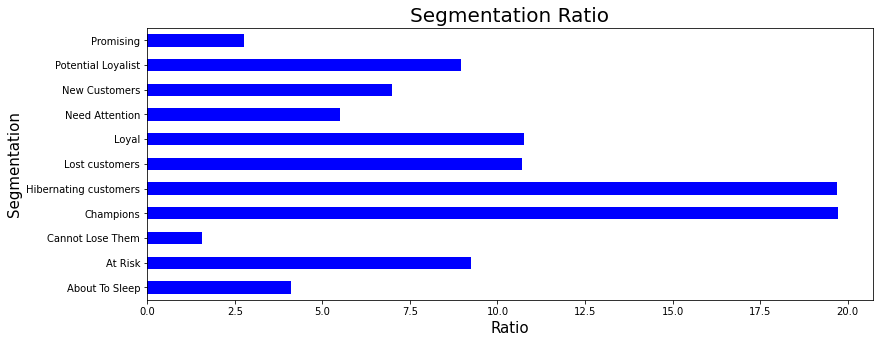

In [ ]:
# Plot segmentation ratio horizontal
df_rfm_all_seg['ratio'].plot(kind='barh', figsize=(13, 5), color='blue')
plt.title('Segmentation Ratio', fontsize=20)
plt.xlabel('Ratio', fontsize=15)
plt.ylabel('Segmentation', fontsize=15)
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 0.98, 'Recency and Frequency Grid')

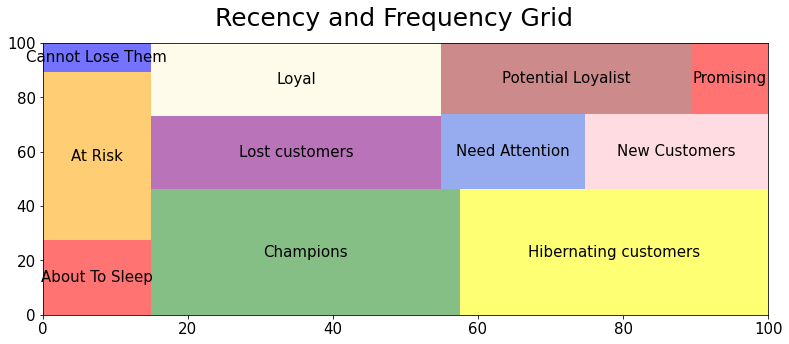

In [ ]:
#Treemap Segmentation Customer
!pip install squarify
import squarify

plt.figure(figsize=(13,5))
plt.rc('font', size=15)
squarify.plot(sizes=df_rfm_all_seg["recency"]["count"], label=df_rfm_all_seg.index,
              color=["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"], alpha=.55)
plt.suptitle("Recency and Frequency Grid", fontsize=25)

## **Modeling Churn Full Data**

In [ ]:
# print rfm score data type
print(df_rfm_all['RFM_score'].dtypes)
# change rfm score to int
df_rfm_all['RFM_score'] = df_rfm_all['RFM_score'].astype(int)
# print rfm score data type
print(df_rfm_all['RFM_score'].dtypes)

int64
int64


In [ ]:
# mean rfm score full data
df_rfm_all['RFM_score'].mean()

9.003107596689333

In [ ]:
df_rfm_all['RFM_score'].max()

15

In [ ]:
#Dipilih batas rfm_score dengan bantuan mean di atas
# 1 : churn=true dan 0 : tidak churn=false
df_rfm_all['churn'] = df_rfm_all['RFM_score'].apply(lambda x: 0 if (x < 16) & (x > 9) else 1)
df_rfm_all.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,churn
0,3,119,33,38231538,4,5,5,14,0
1,15,207,1,146640,3,1,1,5,1
2,18,373,14,17065172,2,5,4,11,0
3,20,55,10,19934542,4,4,4,12,0
4,24,488,5,5270357,2,3,3,8,1


In [ ]:
df_rfm_all.shape

(32501, 9)

In [ ]:
# value count churn
df_rfm_all['churn'].value_counts()

1    17655
0    14846
Name: churn, dtype: int64

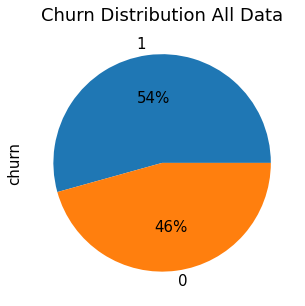

In [ ]:
# pie chart
plt.title('Churn Distribution All Data')
df_rfm_all['churn'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(5,5))

## Labeling Churn Train Bulan 4

In [ ]:
df_train_4['created_at'].min()

Timestamp('2022-01-01 00:00:00')

In [ ]:
df_train_4['created_at'].max()

Timestamp('2022-03-31 00:00:00')

**Recency**

In [ ]:
df_train_4_recency = pd.DataFrame(df_train_4.groupby(by='customer_id', as_index=False)['created_at'].max())
print(df_train_4_recency.shape)

(11151, 2)


In [ ]:
df_train_4_recency.head()

,customer_id,created_at
0,3,2022-02-06
1,15,2022-01-05
2,20,2022-03-28
3,28,2022-03-20
4,32,2022-01-31


In [ ]:
import datetime as dt
present_day = df_train_4_recency['created_at'].max()
present_day

Timestamp('2022-03-31 00:00:00')

In [ ]:
# apply recency berdasarkan 2022-06-30
df_train_4_recency['recency'] = df_train_4_recency['created_at'].apply(lambda x: (present_day - x).days)
print(df_train_4_recency.shape)

(11151, 3)


In [ ]:
df_train_4_recency.head()

,customer_id,created_at,recency
0,3,2022-02-06,53
1,15,2022-01-05,85
2,20,2022-03-28,3
3,28,2022-03-20,11
4,32,2022-01-31,59


**Frekuensi**

In [ ]:
df_train_4_freq = pd.DataFrame(df_train_4.groupby(["customer_id"]).agg({"product_id":"nunique"}).reset_index())
df_train_4_freq.rename(columns={"product_id":"frequency"}, inplace=True)
print(df_train_4_freq.shape)
df_train_4_freq.head()

(11151, 2)


,customer_id,frequency
0,3,2
1,15,1
2,20,6
3,28,5
4,32,1


**Monetary**

In [ ]:
df_train_4_monet = df_train_4.groupby('customer_id', as_index=False)['total_amount'].sum()
df_train_4_monet.columns = ['customer_id', 'monetary']
print(df_train_4_monet.shape)
df_train_4_monet.head()

(11151, 2)


,customer_id,monetary
0,3,864689
1,15,146640
2,20,12982632
3,28,21376536
4,32,251376


**RFM Train Bulan 4**

In [ ]:
df_rfm_train_4 = df_train_4_recency.merge(df_train_4_freq, on='customer_id')
df_rfm_train_4 = df_rfm_train_4.merge(df_train_4_monet, on='customer_id').drop(columns='created_at')
print(df_rfm_train_4.shape)
df_rfm_train_4.head()

(11151, 4)


,customer_id,recency,frequency,monetary
0,3,53,2,864689
1,15,85,1,146640
2,20,3,6,12982632
3,28,11,5,21376536
4,32,59,1,251376


In [ ]:
df_rfm_train_4.describe()

,customer_id,recency,frequency,monetary
count,11151.000000,11151.000000,11151.000000,1.115100e+04
mean,49802.245000,36.714286,2.326518,6.909886e+06
std,29100.733571,25.595795,2.555854,3.396750e+07
min,3.000000,0.000000,1.000000,4.881900e+04
25%,24443.000000,14.000000,1.000000,3.733170e+05
50%,49613.000000,33.000000,1.000000,9.192540e+05
75%,75213.500000,58.000000,3.000000,2.847201e+06
max,99998.000000,89.000000,33.000000,1.571718e+09


Labelling Train Bulan 4

In [ ]:
# Buat Score R, F, dan M (train)
df_rfm_train_4['recency_score']  = pd.qcut(df_rfm_train_4['recency'], 5, labels=[5, 4, 3, 2, 1])
df_rfm_train_4['frequency_score']= pd.qcut(df_rfm_train_4['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_rfm_train_4['monetary_score'] = pd.qcut(df_rfm_train_4['monetary'], 5, labels=[1, 2, 3, 4, 5])
print(df_rfm_train_4.shape)
df_rfm_train_4.head()

(11151, 7)


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,3,53,2,864689,2,3,3
1,15,85,1,146640,1,1,1
2,20,3,6,12982632,5,5,5
3,28,11,5,21376536,5,5,5
4,32,59,1,251376,2,1,1


In [ ]:
# Buat datafram untuk train menggunakan rfm_score integer
df_rfm_train4 = df_rfm_train_4.copy()
df_rfm_train4['RFM_score'] =  df_rfm_train_4.recency_score.astype(int) + df_rfm_train_4.frequency_score.astype(int) + df_rfm_train_4.monetary_score.astype(int)
df_rfm_train4.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,3,53,2,864689,2,3,3,8
1,15,85,1,146640,1,1,1,3
2,20,3,6,12982632,5,5,5,15
3,28,11,5,21376536,5,5,5,15
4,32,59,1,251376,2,1,1,4


In [ ]:
# Buat RFM Score
df_rfm_train_4 = df_rfm_train_4.copy()
df_rfm_train_4['RFM_score'] = df_rfm_train_4.recency_score.astype(str)+ df_rfm_train_4.frequency_score.astype(str) + df_rfm_train_4.monetary_score.astype(str)
df_rfm_train_4.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,3,53,2,864689,2,3,3,233
1,15,85,1,146640,1,1,1,111
2,20,3,6,12982632,5,5,5,555
3,28,11,5,21376536,5,5,5,555
4,32,59,1,251376,2,1,1,211


**Modeling Label**

In [ ]:
# print rfm score data type
print(df_rfm_train4['RFM_score'].dtypes)
# change rfm score to int
df_rfm_train4['RFM_score'] = df_rfm_train4['RFM_score'].astype(int)
# print rfm score data type
print(df_rfm_train4['RFM_score'].dtypes)

int64
int64


In [ ]:
# mean rfm score train
df_rfm_train4['RFM_score'].mean()

9.032104743969152

In [ ]:
# max rfm score train
df_rfm_train4['RFM_score'].max()

15

In [ ]:
#Dipilih batas rfm_score dengan bantuan mean di atas
# 1 : churn=true dan 0 : tidak churn=false
df_rfm_train4['churn'] = df_rfm_train4['RFM_score'].apply(lambda x: 0 if (x < 16) & (x > 9) else 1)
df_rfm_train4.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,churn
0,3,53,2,864689,2,3,3,8,1
1,15,85,1,146640,1,1,1,3,1
2,20,3,6,12982632,5,5,5,15,0
3,28,11,5,21376536,5,5,5,15,0
4,32,59,1,251376,2,1,1,4,1


In [ ]:
# value count churn
df_rfm_train4['churn'].value_counts()

1    6313
0    4838
Name: churn, dtype: int64

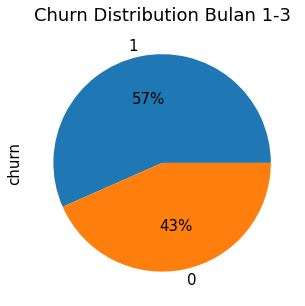

In [ ]:
# pie chart
plt.title('Churn Distribution Bulan 1-3')
df_rfm_train4['churn'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(5,5))

## Labeling Churn Train Bulan 5

In [ ]:
df_train_5['created_at'].min()

Timestamp('2022-02-01 00:00:00')

In [ ]:
df_train_5['created_at'].max()

Timestamp('2022-04-30 00:00:00')

**Recency**

In [ ]:
df_train_5_recency = pd.DataFrame(df_train_5.groupby(by='customer_id', as_index=False)['created_at'].max())
print(df_train_5_recency.shape)

(11293, 2)


In [ ]:
df_train_5_recency.head()

,customer_id,created_at
0,3,2022-04-03
1,20,2022-04-27
2,28,2022-03-20
3,57,2022-03-16
4,61,2022-04-08


In [ ]:
import datetime as dt
present_day = df_train_5_recency['created_at'].max()
present_day

Timestamp('2022-04-30 00:00:00')

In [ ]:
# apply recency berdasarkan 2022-06-30
df_train_5_recency['recency'] = df_train_5_recency['created_at'].apply(lambda x: (present_day - x).days)
print(df_train_5_recency.shape)

(11293, 3)


In [ ]:
df_train_5_recency.head()

,customer_id,created_at,recency
0,3,2022-04-03,27
1,20,2022-04-27,3
2,28,2022-03-20,41
3,57,2022-03-16,45
4,61,2022-04-08,22


**Frekuensi**

In [ ]:
df_train_5_freq = pd.DataFrame(df_train_5.groupby(["customer_id"]).agg({"product_id":"nunique"}).reset_index())
df_train_5_freq.rename(columns={"product_id":"frequency"}, inplace=True)
print(df_train_5_freq.shape)
df_train_5_freq.head()

(11293, 2)


,customer_id,frequency
0,3,2
1,20,8
2,28,5
3,57,1
4,61,1


**Monetary**

In [ ]:
df_train_5_monet = df_train_5.groupby('customer_id', as_index=False)['total_amount'].sum()
df_train_5_monet.columns = ['customer_id', 'monetary']
print(df_train_5_monet.shape)
df_train_5_monet.head()

(11293, 2)


,customer_id,monetary
0,3,808796
1,20,14257706
2,28,21376536
3,57,454952
4,61,909429


**RFM Train Bulan 5**

In [ ]:
df_rfm_train_5 = df_train_5_recency.merge(df_train_5_freq, on='customer_id')
df_rfm_train_5 = df_rfm_train_5.merge(df_train_5_monet, on='customer_id').drop(columns='created_at')
print(df_rfm_train_5.shape)
df_rfm_train_5.head()

(11293, 4)


,customer_id,recency,frequency,monetary
0,3,27,2,808796
1,20,3,8,14257706
2,28,41,5,21376536
3,57,45,1,454952
4,61,22,1,909429


In [ ]:
df_rfm_train_5.describe()

,customer_id,recency,frequency,monetary
count,11293.000000,11293.000000,11293.000000,1.129300e+04
mean,49950.477464,35.613920,2.331267,6.741969e+06
std,29158.000237,25.201256,2.526020,3.540620e+07
min,3.000000,0.000000,1.000000,3.184100e+04
25%,24526.000000,13.000000,1.000000,3.843340e+05
50%,49881.000000,31.000000,1.000000,9.813990e+05
75%,75427.000000,55.000000,3.000000,2.960557e+06
max,99995.000000,88.000000,35.000000,1.570308e+09


**Labelling Train Bulan 5**

In [ ]:
# Buat Score R, F, dan M (train)
df_rfm_train_5['recency_score']  = pd.qcut(df_rfm_train_5['recency'], 5, labels=[5, 4, 3, 2, 1])
df_rfm_train_5['frequency_score']= pd.qcut(df_rfm_train_5['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_rfm_train_5['monetary_score'] = pd.qcut(df_rfm_train_5['monetary'], 5, labels=[1, 2, 3, 4, 5])
print(df_rfm_train_5.shape)
df_rfm_train_5.head()

(11293, 7)


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,3,27,2,808796,3,3,3
1,20,3,8,14257706,5,5,5
2,28,41,5,21376536,2,5,5
3,57,45,1,454952,2,1,2
4,61,22,1,909429,4,1,3


In [ ]:
# Buat datafram untuk train menggunakan rfm_score integer
df_rfm_train5 = df_rfm_train_5.copy()
df_rfm_train5['RFM_score'] =  df_rfm_train5.recency_score.astype(int) + df_rfm_train5.frequency_score.astype(int) + df_rfm_train5.monetary_score.astype(int)
df_rfm_train5.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,3,27,2,808796,3,3,3,9
1,20,3,8,14257706,5,5,5,15
2,28,41,5,21376536,2,5,5,12
3,57,45,1,454952,2,1,2,5
4,61,22,1,909429,4,1,3,8


In [ ]:
# Buat RFM Score
df_rfm_train_5['RFM_score'] = df_rfm_train_5.recency_score.astype(str)+ df_rfm_train_5.frequency_score.astype(str) + df_rfm_train_5.monetary_score.astype(str)
df_rfm_train_5.head()


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,3,27,2,808796,3,3,3,333
1,20,3,8,14257706,5,5,5,555
2,28,41,5,21376536,2,5,5,255
3,57,45,1,454952,2,1,2,212
4,61,22,1,909429,4,1,3,413


**Modeling Label**

In [ ]:
# print rfm score data type
print(df_rfm_train5['RFM_score'].dtypes)
# change rfm score to int
df_rfm_train5['RFM_score'] = df_rfm_train5['RFM_score'].astype(int)
# print rfm score data type
print(df_rfm_train5['RFM_score'].dtypes)

int64
int64


In [ ]:
# mean rfm score train
df_rfm_train5['RFM_score'].mean()

9.036394226511998

In [ ]:
# max rfm score train
df_rfm_train5['RFM_score'].max()

15

In [ ]:
#Dipilih batas rfm_score dengan bantuan mean di atas
# 1 : churn=true dan 0 : tidak churn=false
df_rfm_train5['churn'] = df_rfm_train5['RFM_score'].apply(lambda x: 0 if (x < 16) & (x > 9) else 1)
df_rfm_train5.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,churn
0,3,27,2,808796,3,3,3,9,1
1,20,3,8,14257706,5,5,5,15,0
2,28,41,5,21376536,2,5,5,12,0
3,57,45,1,454952,2,1,2,5,1
4,61,22,1,909429,4,1,3,8,1


In [ ]:
# value count churn
df_rfm_train5['churn'].value_counts()

1    6351
0    4942
Name: churn, dtype: int64

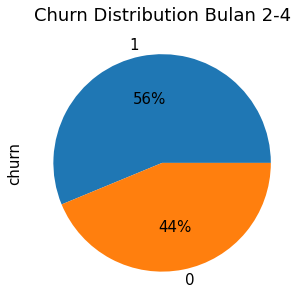

In [ ]:
# pie chart
plt.title('Churn Distribution Bulan 2-4')
df_rfm_train5['churn'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(5,5))

## **Labeling Churn Bulan 6**

In [ ]:
df_train_6['created_at'].min()

Timestamp('2022-03-01 00:00:00')

In [ ]:
df_train_6['created_at'].max()

Timestamp('2022-05-31 00:00:00')

**Recency**

In [ ]:
df_train_6_recency = pd.DataFrame(df_train_6.groupby(by='customer_id', as_index=False)['created_at'].max())
print(df_train_6_recency.shape)

(11579, 2)


In [ ]:
df_train_6_recency.head()

,customer_id,created_at
0,3,2022-04-03
1,20,2022-04-27
2,28,2022-05-26
3,47,2022-05-09
4,57,2022-05-06


In [ ]:
import datetime as dt
present_day = df_train_6_recency['created_at'].max()
present_day

Timestamp('2022-05-31 00:00:00')

In [ ]:
# apply recency berdasarkan 2022-06-30
df_train_6_recency['recency'] = df_train_6_recency['created_at'].apply(lambda x: (present_day - x).days)
print(df_train_6_recency.shape)

(11579, 3)


In [ ]:
df_train_6_recency.head()

,customer_id,created_at,recency
0,3,2022-04-03,58
1,20,2022-04-27,34
2,28,2022-05-26,5
3,47,2022-05-09,22
4,57,2022-05-06,25


**Frekuensi**

In [ ]:
df_train_6_freq = pd.DataFrame(df_train_6.groupby(["customer_id"]).agg({"product_id":"nunique"}).reset_index())
df_train_6_freq.rename(columns={"product_id":"frequency"}, inplace=True)
print(df_train_6_freq.shape)
df_train_6_freq.head()

(11579, 2)


,customer_id,frequency
0,3,1
1,20,8
2,28,5
3,47,1
4,57,3


**Monetary**

In [ ]:
df_train_6_monet = df_train_6.groupby('customer_id', as_index=False)['total_amount'].sum()
df_train_6_monet.columns = ['customer_id', 'monetary']
print(df_train_6_monet.shape)
df_train_6_monet.head()

(11579, 2)


,customer_id,monetary
0,3,312890
1,20,14257706
2,28,23359092
3,47,199686
4,57,5371064


**RFM Train Bulan 6**

In [ ]:
df_rfm_train_6 = df_train_6_recency.merge(df_train_6_freq, on='customer_id')
df_rfm_train_6 = df_rfm_train_6.merge(df_train_6_monet, on='customer_id').drop(columns='created_at')
print(df_rfm_train_6.shape)
df_rfm_train_6.head()

(11579, 4)


,customer_id,recency,frequency,monetary
0,3,58,1,312890
1,20,34,8,14257706
2,28,5,5,23359092
3,47,22,1,199686
4,57,25,3,5371064


In [ ]:
df_rfm_train_6.describe()

,customer_id,recency,frequency,monetary
count,11579.000000,11579.000000,11579.000000,1.157900e+04
mean,49838.161499,36.675015,2.412384,7.233649e+06
std,29234.089634,25.710804,2.671964,4.009828e+07
min,3.000000,0.000000,1.000000,3.184100e+04
25%,24409.000000,14.000000,1.000000,3.947800e+05
50%,49535.000000,33.000000,1.000000,1.021382e+06
75%,75299.500000,56.000000,3.000000,3.185282e+06
max,99995.000000,91.000000,42.000000,1.876894e+09


Labelling Train Bulan 6

In [ ]:
# Buat Score R, F, dan M (train)
df_rfm_train_6['recency_score']  = pd.qcut(df_rfm_train_6['recency'], 5, labels=[5, 4, 3, 2, 1])
df_rfm_train_6['frequency_score']= pd.qcut(df_rfm_train_6['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_rfm_train_6['monetary_score'] = pd.qcut(df_rfm_train_6['monetary'], 5, labels=[1, 2, 3, 4, 5])
print(df_rfm_train_6.shape)
df_rfm_train_6.head()

(11579, 7)


,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,3,58,1,312890,2,1,1
1,20,34,8,14257706,3,5,5
2,28,5,5,23359092,5,5,5
3,47,22,1,199686,4,1,1
4,57,25,3,5371064,4,4,5


In [ ]:
# Buat datafram untuk train menggunakan rfm_score integer
df_rfm_train_6['RFM_score'] =  df_rfm_train_6.recency_score.astype(int) + df_rfm_train_6.frequency_score.astype(int) + df_rfm_train_6.monetary_score.astype(int)
df_rfm_train_6.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,3,58,1,312890,2,1,1,4
1,20,34,8,14257706,3,5,5,13
2,28,5,5,23359092,5,5,5,15
3,47,22,1,199686,4,1,1,6
4,57,25,3,5371064,4,4,5,13


**Modeling Label**

In [ ]:
# print rfm score data type
print(df_rfm_train_6['RFM_score'].dtypes)
# change rfm score to int
df_rfm_train_6['RFM_score'] = df_rfm_train_6['RFM_score'].astype(int)
# print rfm score data type
print(df_rfm_train_6['RFM_score'].dtypes)

int64
int64


In [ ]:
# mean rfm score train
df_rfm_train_6['RFM_score'].mean()

9.026772605579065

In [ ]:
# max rfm score train
df_rfm_train_6['RFM_score'].max()

15

In [ ]:
#Dipilih batas rfm_score dengan bantuan mean di atas
# 1 : churn=true dan 0 : tidak churn=false
df_rfm_train_6['churn'] = df_rfm_train_6['RFM_score'].apply(lambda x: 0 if (x < 16) & (x > 9) else 1)
df_rfm_train_6.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,churn
0,3,58,1,312890,2,1,1,4,1
1,20,34,8,14257706,3,5,5,13,0
2,28,5,5,23359092,5,5,5,15,0
3,47,22,1,199686,4,1,1,6,1
4,57,25,3,5371064,4,4,5,13,0


In [ ]:
# value count churn
df_rfm_train_6['churn'].value_counts()

1    6455
0    5124
Name: churn, dtype: int64

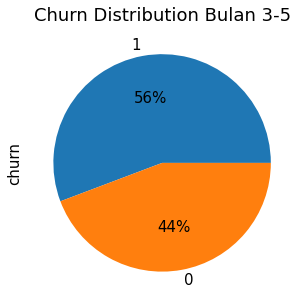

In [ ]:
# pie chart
plt.title('Churn Distribution Bulan 3-5')
df_rfm_train_6['churn'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(5,5))

# Merge Seluruh Churn Data Training

In [ ]:
df1 = pd.DataFrame(df_rfm_train4)
df2 = pd.DataFrame(df_rfm_train5)
df3 = pd.DataFrame(df_rfm_train_6)
frame = [df1,df2,df3]
df_rfm_train = pd.concat(frame)

In [ ]:
df_rfm_train

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,churn
0,3,53,2,864689,2,3,3,8,1
1,15,85,1,146640,1,1,1,3,1
2,20,3,6,12982632,5,5,5,15,0
3,28,11,5,21376536,5,5,5,15,0
4,32,59,1,251376,2,1,1,4,1
...,...,...,...,...,...,...,...,...,...
11574,99978,11,1,969600,5,3,3,11,0
11575,99985,66,3,5536755,1,5,5,11,0
11576,99986,57,1,236247,2,3,1,6,1
11577,99988,46,2,381166,2,4,2,8,1


# Basseline Model

In [ ]:
# Buat model
X = df_rfm_train.drop(['churn', 'RFM_score','customer_id'], axis=1)
y = df_rfm_train['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2)

In [ ]:
#KKN MODEL
kkn_model = KNeighborsClassifier(n_neighbors = 11)
kkn_model.fit(X_train,y_train)
predicted_y = kkn_model.predict(X_test)
accuracy_kkn = kkn_model.score(X_test,y_test)
print("KKN MODEL accuracy is :",accuracy_kkn)

KKN MODEL accuracy is : 0.8276672871558735


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def model(classifier):

    classifier.fit(X_test,y_test)
    prediction = classifier.predict(X_train)
    print("ACCURACY : ",'{0:.2%}'.format(accuracy_score(y_train,prediction)))
    print("CROSS VALIDATION SCORE : ",'{0:.2%}'.format(cross_val_score(classifier,X_test,y_test,cv = 10,scoring = 'accuracy').mean()))
    print("ROC_AUC SCORE : ",'{0:.2%}'.format(roc_auc_score(y_train,prediction)))
    plot_roc_curve(classifier, X_train,y_train)
    plt.title('ROC_AUC_PLOT')
    plt.show()

ACCURACY :  83.32%
CROSS VALIDATION SCORE :  83.07%
ROC_AUC SCORE :  82.95%


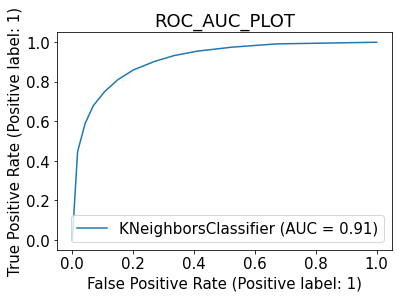

In [ ]:
kkn_model = KNeighborsClassifier(n_neighbors = 11)
model(kkn_model)

In [ ]:
# Classification Report
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4430
           1       0.84      0.85      0.85      5777

    accuracy                           0.83     10207
   macro avg       0.83      0.82      0.82     10207
weighted avg       0.83      0.83      0.83     10207



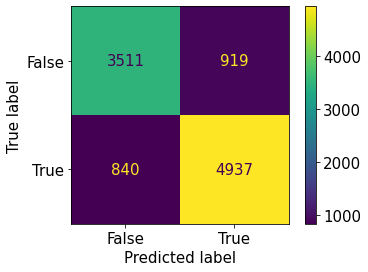

In [ ]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
#LOGISTIC REGRESSION MODEL
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
predicted_y = lr_model.predict(X_test)
accuracy_lr = lr_model.score(X_test,y_test)
print("LOGISTIC REGRESSION MODEL accuracy is :",accuracy_lr)

LOGISTIC REGRESSION MODEL accuracy is : 0.4340158714607622


ACCURACY :  43.98%
CROSS VALIDATION SCORE :  47.83%
ROC_AUC SCORE :  50.00%


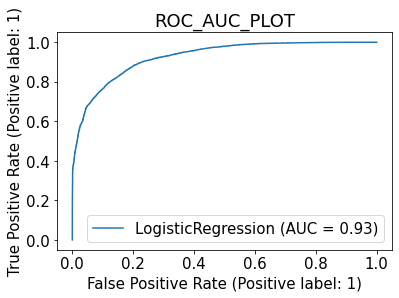

In [ ]:
lr_model = LogisticRegression()
model(lr_model)

In [ ]:
# Classification Report
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.43      1.00      0.61      4430
           1       0.00      0.00      0.00      5777

    accuracy                           0.43     10207
   macro avg       0.22      0.50      0.30     10207
weighted avg       0.19      0.43      0.26     10207



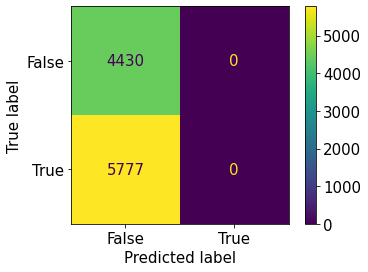

In [ ]:
#confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, predicted_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# Machine Learning Models

In [ ]:
# Buat model
X = df_rfm_train.drop(['churn', 'RFM_score','customer_id'], axis=1)
y = df_rfm_train['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#RANDOM FOREST MODEL
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train,y_train)
prediction_test = model_rf.predict(X_test)
accuracy_rf = model_rf.score(X_test,y_test)
print("RANDOM FOREST MODEL accuracy is :",accuracy_rf)

RANDOM FOREST MODEL accuracy is : 0.9976487876561352


ACCURACY :  99.66%
CROSS VALIDATION SCORE :  99.72%
ROC_AUC SCORE :  99.64%


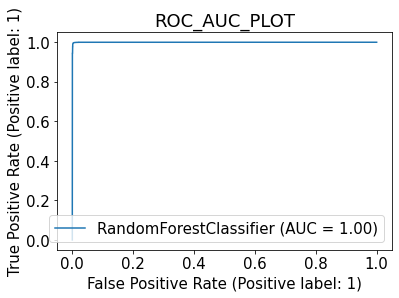

In [ ]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model(model_rf)

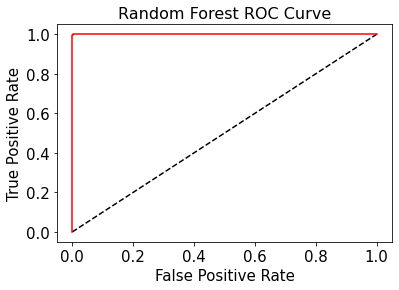

In [ ]:
y_rfpred_prob = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

In [ ]:
# Classification Report
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2972
           1       1.00      1.00      1.00      3833

    accuracy                           1.00      6805
   macro avg       1.00      1.00      1.00      6805
weighted avg       1.00      1.00      1.00      6805



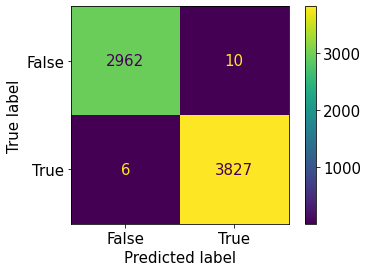

In [ ]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
#DECISION TREE MODEL
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
predicted_y = dt_model.predict(X_test)
accuracy_dt = dt_model.score(X_test,y_test)
print("DECISION TREE MODEL accuracy is :",accuracy_dt)

DECISION TREE MODEL accuracy is : 0.9988243938280676


ACCURACY :  99.67%
CROSS VALIDATION SCORE :  99.68%
ROC_AUC SCORE :  99.66%


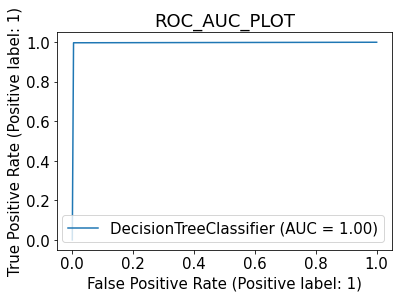

In [ ]:
dt_model = DecisionTreeClassifier()
model(dt_model)

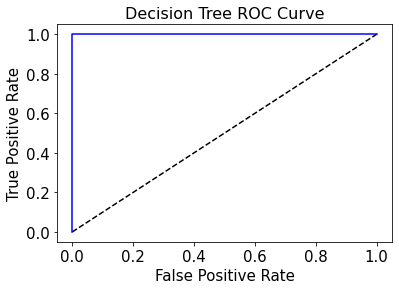

In [ ]:
y_rfpred_prob = dt_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Decision Tree',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve',fontsize=16)
plt.show();

In [ ]:
# Classification Report
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2972
           1       1.00      1.00      1.00      3833

    accuracy                           1.00      6805
   macro avg       1.00      1.00      1.00      6805
weighted avg       1.00      1.00      1.00      6805



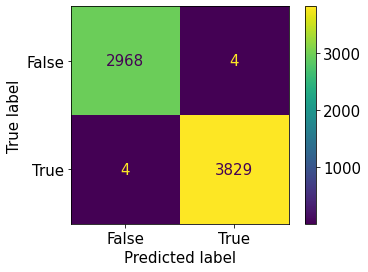

In [ ]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
X_test

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
9579,55,1,127291,2,3,1
5533,19,1,151846,4,2,1
9251,54,1,191012,2,3,1
5836,42,1,2361395,3,2,4
344,85,1,744034,1,1,3
...,...,...,...,...,...,...
101,20,13,46129998,4,5,5
1457,11,2,953534,5,3,3
3876,68,1,265596,1,1,1
6024,59,2,1711252,2,4,4


In [ ]:
y_test

9579    1
5533    1
9251    1
5836    1
344     1
       ..
101     0
1457    0
3876    1
6024    0
4010    1
Name: churn, Length: 6805, dtype: int64

In [ ]:
predict = predicted_y.tolist()

In [ ]:
#merge_final data test
predict_data = X_test.copy()
predict_data['y_test'] = y_test
predict_data['predict'] = predict

In [ ]:
predict_data

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,y_test,predict
9579,55,1,127291,2,3,1,1,1
5533,19,1,151846,4,2,1,1,1
9251,54,1,191012,2,3,1,1,1
5836,42,1,2361395,3,2,4,1,1
344,85,1,744034,1,1,3,1,1
...,...,...,...,...,...,...,...,...
101,20,13,46129998,4,5,5,0,0
1457,11,2,953534,5,3,3,0,0
3876,68,1,265596,1,1,1,1,1
6024,59,2,1711252,2,4,4,0,0


In [ ]:
predict_data[(predict_data['y_test'] != predict_data['predict'])]

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,y_test,predict
3386,41,1,1401016,3,1,4,1,0
4119,41,1,1513752,2,2,4,1,0
9746,30,3,671403,3,5,2,0,1
3204,64,3,4186518,1,4,4,1,0
7289,49,4,4116158,2,5,4,0,1
1895,3,2,319342,5,3,2,0,1
7901,65,3,4221921,1,4,4,1,0
8650,41,1,1820948,3,3,4,0,1


Dari output diatas pembuktian bahwa y_test != data aktual, sedangkan predict, data hasil predict menggunakan prediction random forest

# Prediction Bulan 8 Model Machine Learning Decision Tree

In [ ]:
# Predict df_rfm_test Decision Tree Model
df_rfm_test['churn'] = dt_model.predict(df_rfm_test.drop(['RFM_score','customer_id'], axis=1))
df_rfm_test.head()

NameError: ignored

In [ ]:
# value count churn
print(df_rfm_test['churn'].value_counts())

# pie chart
plt.title('Churn Distribution Bulan 8 Model Decision Tree')
df_rfm_test['churn'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(5,5))

# **Conclusion**

1. Recency
Recency pada dataframe digunakan untuk
mengukur nilai pelanggan berdasarkan
rentang waktu (tanggal, bulan, tahun)
transaksi terakhir pelanggan sampai saat
ini. Semakin kecil rentang waktu maka nilai
recency semakin besar.
2. Frequency
Frequency pada dataframe digunakan untuk
mengukur nilai pelanggan berdasarkan
jumlah transaksi yang dilakukan pelanggan
dalam satu periode. Semakin banyak
jumlah transaksi yang dilakukan maka nilai
f semakin besar.
3. Monetary
Monetary pada dataframe digunakan untuk
mengukur nilai pelanggan berdasarkan
jumlah besaran uang yang dikeluarkan
pelanggan dalam satu periode. Semakin
banyak jumlah besaran uang yang
dikeluarkan pelanggan maka nilai M
semakin besar.

Berdasarkan data yang telah diolah dapat diprediksi bahwa jumlah customer yang churn sangatlah banyak, yaitu mencapai lebih dari 50%. Hal tersebut disebabkan banyaknya customer yang hanya melakukan satu kali transaksi saja dan juga jumlah customer yang tidak melakukan pembelian tidak sedikit. Untuk mengatasi permasalah tersebut tim marketing dari perusahan Fashion Campus perlu membuat rencana dalam mengembalikan para customer yang churn.


Untuk memprediksi bulan ke-8, maka kita menggunakan model machine learning Decision Tree. Karena hasil pada akurasi Decision Tree menunjukkan nilai 99,8% sedangkan akurasi model Random Forest sebesar 99.7%. Sehingga prediksi menunjukkan bahwa terdapat sebanyak 56% customer churn, dengan data testing bulan 7.